(multivariate_normal_v11)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 多元正态分布

```{contents} 目录
:depth: 2
```

## 概述

本讲座介绍概率论、统计学和经济学中的一个重要工具，即**多元正态分布**。

在本讲座中，你将学习以下公式：

* 长度为N的随机向量$x$的联合分布
* $x$的所有子向量的边际分布
* $x$的子向量在其他子向量条件下的条件分布

我们将使用多元正态分布来构建一些有用的模型：

* 智商(IQ)的因子分析模型
* 两种独立固有能力(如数学和语言能力)的因子分析模型
* 更一般的因子分析模型
* 作为因子分析模型近似的主成分分析(PCA)
* 由线性随机差分方程生成的时间序列
* 最优线性滤波理论

## 多元正态分布

本讲将定义一个Python类`MultivariateNormal`，用于生成与多元正态分布相关的**边缘**和**条件**分布。

对于多元正态分布，非常方便的是：

- 条件期望等于线性最小二乘投影
- 条件分布由多元线性回归表征

我们将把我们的Python类应用到一些例子中。

我们使用以下导入：

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
from numba import jit
import statsmodels.api as sm

假设 $N \times 1$ 随机向量 $z$ 具有多元正态概率密度。

这意味着概率密度的形式为

$$
f\left(z;\mu,\Sigma\right)=\left(2\pi\right)^{-\left(\frac{N}{2}\right)}\det\left(\Sigma\right)^{-\frac{1}{2}}\exp\left(-.5\left(z-\mu\right)^{\prime}\Sigma^{-1}\left(z-\mu\right)\right)
$$

其中 $\mu=Ez$ 是随机向量 $z$ 的均值，$\Sigma=E\left(z-\mu\right)\left(z-\mu\right)^\prime$ 是 $z$ 的协方差矩阵。

协方差矩阵 $\Sigma$ 是对称且正定的。

In [2]:
@jit
def f(z, μ, Σ):
    """
    多元正态分布的密度函数。

    参数
    ---------------
    z: ndarray(float, dim=2)
        随机向量，N x 1
    μ: ndarray(float, dim=1 or 2)
        z的均值，N x 1
    Σ: ndarray(float, dim=2)
        z的协方差矩阵，N x 1
    """

    z = np.atleast_2d(z)
    μ = np.atleast_2d(μ)
    Σ = np.atleast_2d(Σ)

    N = z.size

    temp1 = np.linalg.det(Σ) ** (-1/2)
    temp2 = np.exp(-.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

对于某个整数 $k\in \{1,\dots, N-1\}$，将 $z$ 分割为

$$
z=\left[\begin{array}{c} z_{1}\\ z_{2} \end{array}\right],
$$

其中 $z_1$ 是一个 $\left(N-k\right)\times1$ 向量，$z_2$ 是一个 $k\times1$ 向量。

令

$$
\mu=\left[\begin{array}{c}
\mu_{1}\\
\mu_{2}
\end{array}\right],\quad\Sigma=\left[\begin{array}{cc}
\Sigma_{11} & \Sigma_{12}\\
\Sigma_{21} & \Sigma_{22}
\end{array}\right]
$$

为 $\mu$ 和 $\Sigma$ 的相应分割。

$z_1$ 的**边缘**分布是：

- 多元正态分布，均值为 $\mu_1$，协方差矩阵为 $\Sigma_{11}$。

$z_2$ 的**边缘**分布是：

- 多元正态分布，均值为 $\mu_2$，协方差矩阵为 $\Sigma_{22}$。

在给定 $z_2$ 条件下，$z_1$ 的**条件**分布是：

- 多元正态分布，均值为

$$
\hat{\mu}_1 = \mu_1 + \beta \left(z_2 -\mu_2\right)
$$

协方差矩阵为

$$
\hat{\Sigma}_{11}=\Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}=\Sigma_{11}-\beta\Sigma_{22}\beta^{\prime}
$$

其中

$$

\beta = \Sigma_{12}\Sigma_{22}^{-1}
$$

是一个 $\left(N-k\right) \times k$ 的**总体回归系数**矩阵，表示 $(N -k) \times 1$ 随机向量 $z_1 - \mu_1$ 对 $k \times 1$ 随机向量 $z_2 - \mu_2$ 的回归系数。

以下类构造了一个多元正态分布实例，具有两个方法：

- `partition`方法计算 $\beta$，以 $k$ 作为输入
- `cond_dist`方法计算 $z_1$ 在给定 $z_2$ 条件下的分布，或 $z_2$ 在给定 $z_1$ 条件下的分布

In [3]:
class MultivariateNormal:
    """
    多元正态分布类。

    参数
    ----------
    μ: ndarray(float, dim=1)
        z的均值，N乘1
    Σ: ndarray(float, dim=2)
        z的协方差矩阵，N乘1

    属性
    ---------
    μ, Σ:
        见参数
    μs: list(ndarray(float, dim=1))
        按顺序排列的均值向量μ1和μ2的列表
    Σs: list(list(ndarray(float, dim=2)))
        按顺序排列的协方差矩阵Σ11、Σ12、Σ21、Σ22的二维列表
    βs: list(ndarray(float, dim=1))
        按顺序排列的回归系数β1和β2的列表
    """

    def __init__(self, μ, Σ):
        "初始化"
        self.μ = np.array(μ)
        self.Σ = np.atleast_2d(Σ)

    def partition(self, k):
        """
        给定k，将随机向量z分割为大小为k的向量z1和大小为N-k的向量z2。
        相应地将均值向量μ分割为μ1和μ2，将协方差矩阵Σ分割为Σ11、Σ12、
        Σ21、Σ22。使用分割后的数组计算回归系数β1和β2。
        """
        μ = self.μ
        Σ = self.Σ

        self.μs = [μ[:k], μ[k:]]
        self.Σs = [[Σ[:k, :k], Σ[:k, k:]],
                   [Σ[k:, :k], Σ[k:, k:]]]

        self.βs = [self.Σs[0][1] @ np.linalg.inv(self.Σs[1][1]),
                   self.Σs[1][0] @ np.linalg.inv(self.Σs[0][0])]

    def cond_dist(self, ind, z):
        """
        计算在给定z2条件下z1的条件分布，或反之。
        参数ind决定我们是计算z1的条件分布(ind=0)还是z2的条件分布(ind=1)。

        返回值
        ---------
        μ_hat: ndarray(float, ndim=1)
            z1或z2的条件均值。
        Σ_hat: ndarray(float, ndim=2)
            z1或z2的条件协方差矩阵。
        """
        β = self.βs[ind]
        μs = self.μs
        Σs = self.Σs

        μ_hat = μs[ind] + β @ (z - μs[1-ind])
        Σ_hat = Σs[ind][ind] - β @ Σs[1-ind][1-ind] @ β.T

        return μ_hat, Σ_hat

让我们通过一系列示例来运用这段代码。

我们先从一个简单的二元示例开始；之后我们将转向三元示例。

我们将使用我们的`MultivariateNormal`类来计算一些条件分布的总体矩。

为了增添趣味，我们还将通过生成模拟数据并计算线性最小二乘回归来计算相关总体回归的样本类比。

我们将比较这些模拟数据的线性最小二乘回归与其总体对应值。

## 二元示例

我们从由以下参数确定的二元正态分布开始

$$
\mu=\left[\begin{array}{c}
.5 \\
1.0
\end{array}\right],\quad\Sigma=\left[\begin{array}{cc}
1 & .5\\
.5 & 1
\end{array}\right]
$$

In [4]:
μ = np.array([.5, 1.])
Σ = np.array([[1., .5], [.5 ,1.]])

# 构建多元正态分布实例
multi_normal = MultivariateNormal(μ, Σ)

In [5]:
k = 1 # 选择分区

# 分区并计算回归系数
multi_normal.partition(k)
multi_normal.βs[0],multi_normal.βs[1]

(array([[0.5]]), array([[0.5]]))

让我们说明一下你可以_把任何东西都可以回归到其他任何东西上_这个事实。

我们已经计算了所需的一切，可以计算两条回归线，一条是$z_2$对$z_1$的回归，另一条是$z_1$对$z_2$的回归。

我们将这些回归表示为

$$
z_1 = a_1 + b_1 z_2 + \epsilon_1
$$

和

$$
z_2 = a_2 + b_2 z_1 + \epsilon_2
$$

其中我们有总体最小二乘正交条件

$$
E \epsilon_1 z_2 = 0
$$

和

$$
E \epsilon_2 z_1 = 0
$$

让我们计算$a_1, a_2, b_1, b_2$。

In [6]:
beta = multi_normal.βs

a1 = μ[0] - beta[0]*μ[1]
b1 = beta[0]

a2 = μ[1] - beta[1]*μ[0]
b2 = beta[1]

让我们打印出截距和斜率。

对于 $z_1$ 对 $z_2$ 的回归，我们有

In [7]:
print ("a1 = ", a1)
print ("b1 = ", b1)

a1 =  [[0.]]
b1 =  [[0.5]]


对于 $z_2$ 对 $z_1$ 的回归，我们有

In [8]:
print ("a2 = ", a2)
print ("b2 = ", b2)

a2 =  [[0.75]]
b2 =  [[0.5]]


现在让我们绘制这两条回归线并仔细观察。

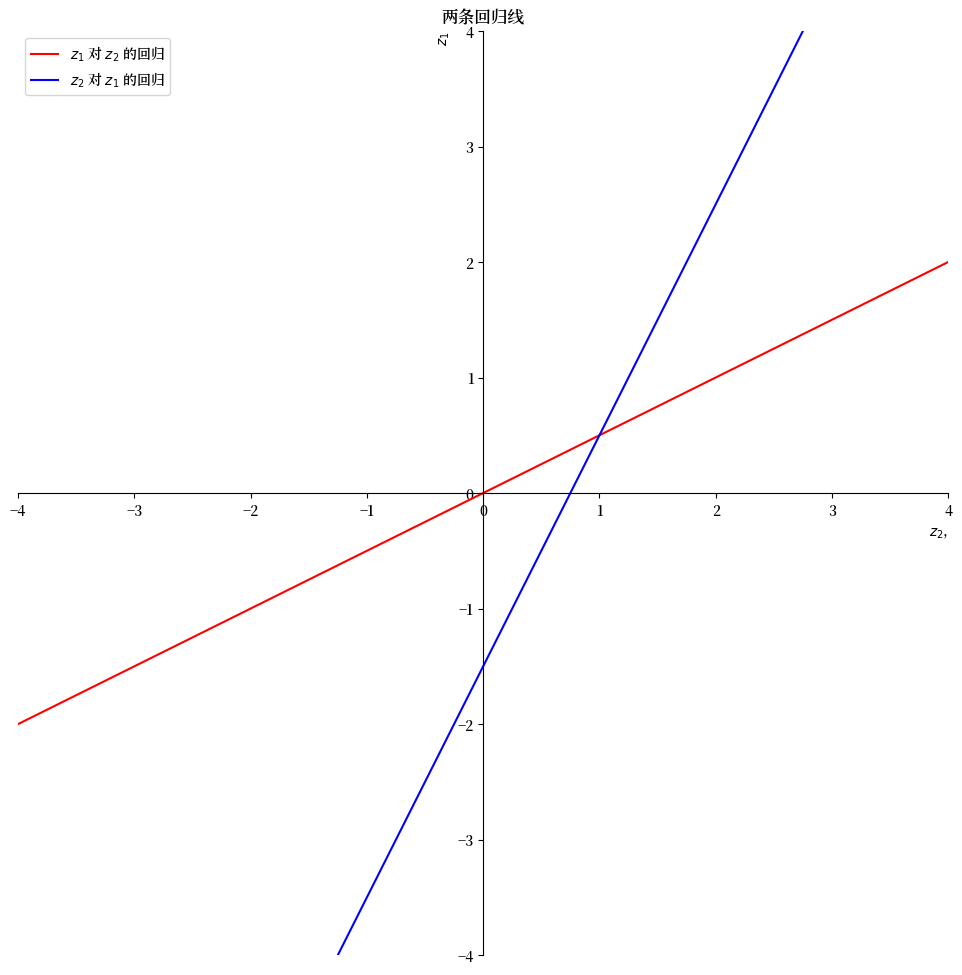

In [9]:
z2 = np.linspace(-4,4,100)


a1 = np.squeeze(a1)
b1 = np.squeeze(b1)

a2 = np.squeeze(a2)
b2 = np.squeeze(b2)

z1  = b1*z2 + a1


z1h = z2/b2 - a2/b2


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel('$z_1$', loc = 'top')
plt.xlabel('$z_2$,', loc = 'right')
plt.title('两条回归线')
plt.plot(z2,z1, 'r', label = "$z_1$ 对 $z_2$ 的回归")
plt.plot(z2,z1h, 'b', label = "$z_2$ 对 $z_1$ 的回归")
plt.legend()
plt.show()

红线是在给定 $z_2$ 条件下 $z_1$ 的期望值。

红线的截距和斜率是

In [10]:
print("a1 = ", a1)
print("b1 = ", b1)

a1 =  0.0
b1 =  0.5


蓝线是在给定 $z_1$ 条件下 $z_2$ 的期望值。

蓝线的截距和斜率是

In [11]:
print("-a2/b2 = ", - a2/b2)
print("1/b2 = ", 1/b2)

-a2/b2 =  -1.5
1/b2 =  2.0


我们可以使用这些回归线或我们的代码来计算条件期望。

让我们计算在给定$z_1=5$条件下$z_2$分布的均值和方差。

之后我们将对调回归中左右两边的变量。

In [12]:
# compute the cond. dist. of z1
ind = 1
z1 = np.array([5.]) # given z1

μ2_hat, Σ2_hat = multi_normal.cond_dist(ind, z1)
print('μ2_hat, Σ2_hat = ', μ2_hat, Σ2_hat)

μ2_hat, Σ2_hat =  [3.25] [[0.75]]


现在让我们计算在 $z_2=5$ 的条件下 $z_1$ 的分布的均值和方差。

In [13]:
# 计算 z1 的条件分布
ind = 0
z2 = np.array([5.]) # 给定 z2

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)
print('μ1_hat, Σ1_hat = ', μ1_hat, Σ1_hat)

μ1_hat, Σ1_hat =  [2.5] [[0.75]]


让我们比较前面的总体均值和方差与从大样本抽取并对$z_1 - \mu_1$和$z_2 - \mu_2$进行回归的结果。

我们知道

$$
E z_1 | z_2 = \left(\mu_1 - \beta \mu_2 \right) + \beta z_2
$$

这可以重新整理为

$$
z_1 - \mu_1 = \beta \left( z_2 - \mu_2 \right) + \epsilon,
$$

我们预计，随着样本量越来越大，估计的OLS系数将收敛到$\beta$，$\epsilon$的估计方差将收敛到$\hat{\Sigma}_1$。

In [14]:
n = 1_000_000 # 样本量

# 模拟多元正态随机向量
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, 0]
z2_data = data[:, 1]

# OLS回归
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

让我们比较前面的总体 $\beta$ 与 $z_2 - \mu_2$ 的 OLS 样本估计值

In [15]:
multi_normal.βs[0], results.params

(array([[0.5]]), array([0.49898302]))

让我们将我们的总体 $\hat{\Sigma}_1$ 与 $\epsilon$ 的自由度调整后的方差估计进行比较

In [16]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.75]]), 0.7491102087368485)

最后，让我们计算$\hat{E z_1 | z_2}$的估计值并将其与$\hat{\mu}_1$进行比较

In [17]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([2.5]), array([2.4959321]))

因此，在每种情况下，对于我们的大样本量，样本类比都与其总体对应值非常接近。

大数定律解释了为什么样本类比会接近总体对象。

## 三变量示例

让我们将代码应用到一个三变量示例中。

我们将按如下方式指定均值向量和协方差矩阵。

In [18]:
μ = np.random.random(3)
C = np.random.random((3, 3))
Σ = C @ C.T # positive semi-definite

multi_normal = MultivariateNormal(μ, Σ)

In [19]:
μ, Σ

(array([0.23712981, 0.91400481, 0.84232708]),
 array([[0.81828728, 0.53745426, 0.68115546],
        [0.53745426, 1.1413295 , 0.66991637],
        [0.68115546, 0.66991637, 0.6400623 ]]))

In [20]:
k = 1
multi_normal.partition(k)

让我们计算在给定 $z_{2}=\left[\begin{array}{c} 2\\ 5 \end{array}\right]$ 条件下 $z_1$ 的分布。

In [21]:
ind = 0
z2 = np.array([2., 5.])

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)

In [22]:
n = 1_000_000
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, :k]
z2_data = data[:, k:]

In [23]:
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

如上所述，我们依次比较总体和样本回归系数、条件协方差矩阵和条件均值向量。

In [24]:
multi_normal.βs[0], results.params

(array([[-0.39864898,  1.48144476]]), array([-0.39857892,  1.481409  ]))

In [25]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.02344868]]), 0.023399998755823166)

In [26]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([5.9635617]), array([5.96348908]))

再一次，样本类比很好地近似了它们的总体对应值。

## 一维智力（IQ）

让我们来看一个更接近现实生活的例子，即从一系列测试分数中推断出一个称为IQ的一维智力测量值。

第$i$个测试分数$y_i$等于未知标量IQ $\theta$和随机变量$w_{i}$的和。

$$
y_{i} = \theta + \sigma_y w_i, \quad i=1,\dots, n
$$

对于一群人的IQ分布是一个正态随机变量，描述如下：

$$
\theta = \mu_{\theta} + \sigma_{\theta} w_{n+1}.
$$

我们假设测试分数中的噪声$\{w_i\}_{i=1}^N$是独立同分布的，且与IQ不相关。

我们还假设$\{w_i\}_{i=1}^{n+1}$是独立同分布的标准正态分布：

$$
\boldsymbol{w}=
\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{n}\\
w_{n+1}
\end{array}\right]\sim N\left(0,I_{n+1}\right)
$$

以下系统描述了我们感兴趣的$(n+1) \times 1$随机向量$X$：

$$

X=\left[\begin{array}{c}
y_{1}\\
y_{2}\\
\vdots\\
y_{n}\\
\theta
\end{array}\right]=\left[\begin{array}{c}
\mu_{\theta}\\
\mu_{\theta}\\
\vdots\\
\mu_{\theta}\\
\mu_{\theta}
\end{array}\right]+\left[\begin{array}{ccccc}
\sigma_{y} & 0 & \cdots & 0 & \sigma_{\theta}\\
0 & \sigma_{y} & \cdots & 0 & \sigma_{\theta}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{y} & \sigma_{\theta}\\
0 & 0 & \cdots & 0 & \sigma_{\theta}
\end{array}\right]\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{n}\\
w_{n+1}
\end{array}\right],
$$

或等价地，

$$
X=\mu_{\theta}\boldsymbol{1}_{n+1}+D\boldsymbol{w}
$$

其中 $X = \begin{bmatrix} y \cr \theta \end{bmatrix}$，
$\boldsymbol{1}_{n+1}$ 是一个大小为 $n+1$ 的全1向量，
而 $D$ 是一个 $n+1$ 乘 $n+1$ 的矩阵。

让我们定义一个Python函数来构造我们已知遵循多元正态分布的随机向量 $X$ 的均值 $\mu$ 和协方差矩阵 $\Sigma$。

作为参数，该函数接收测试次数 $n$、IQ分布的均值 $\mu_{\theta}$ 和标准差 $\sigma_\theta$，以及测试分数中随机性的标准差 $\sigma_{y}$。

In [27]:
def construct_moments_IQ(n, μθ, σθ, σy):

    μ_IQ = np.full(n+1, μθ)

    D_IQ = np.zeros((n+1, n+1))
    D_IQ[range(n), range(n)] = σy
    D_IQ[:, n] = σθ

    Σ_IQ = D_IQ @ D_IQ.T

    return μ_IQ, Σ_IQ, D_IQ

现在让我们考虑这个模型的一个具体实例。

假设我们记录了$50$个测试分数，并且我们知道
$\mu_{\theta}=100$，$\sigma_{\theta}=10$，以及
$\sigma_{y}=10$。

我们可以使用`construct_moments_IQ`函数轻松计算$X$的均值向量和协方差矩阵，如下所示。

In [28]:
n = 50
μθ, σθ, σy = 100., 10., 10.

μ_IQ, Σ_IQ, D_IQ = construct_moments_IQ(n, μθ, σθ, σy)
μ_IQ, Σ_IQ, D_IQ

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.]),
 array([[200., 100., 100., ..., 100., 100., 100.],
        [100., 200., 100., ..., 100., 100., 100.],
        [100., 100., 200., ..., 100., 100., 100.],
        ...,
        [100., 100., 100., ..., 200., 100., 100.],
        [100., 100., 100., ..., 100., 200., 100.],
        [100., 100., 100., ..., 100., 100., 100.]]),
 array([[10.,  0.,  0., ...,  0.,  0., 10.],
        [ 0., 10.,  0., ...,  0.,  0., 10.],
        [ 0.,  0., 10., ...,  0.,  0., 10.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0., 10.],
        [ 0.,  0.,  0., ...,  0., 10., 10.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]))

我们现在可以使用我们的`MultivariateNormal`类来构建一个实例，然后按照我们的需要对均值向量和协方差矩阵进行分割。

我们想要对IQ（即随机变量$\theta$，_我们不知道的_）基于测试分数向量$y$（_我们知道的_）进行回归。

我们选择`k=n`，这样$z_{1} = y$且$z_{2} = \theta$。

In [29]:
multi_normal_IQ = MultivariateNormal(μ_IQ, Σ_IQ)

k = n
multi_normal_IQ.partition(k)

使用生成器 `multivariate_normal`，我们可以从我们的分布中抽取一次随机向量，然后计算在给定测试分数条件下 $\theta$ 的分布。

让我们来做这个，然后打印出一些相关的数值。

In [30]:
x = np.random.multivariate_normal(μ_IQ, Σ_IQ)
y = x[:-1] # 测试分数
θ = x[-1]  # 智商

In [31]:
# 真实值
θ

104.6551625652423

方法 `cond_dist` 接收测试分数 $y$ 作为输入，并返回智商 $\theta$ 的条件正态分布。

在下面的代码中，`ind` 设置回归右侧的变量。

根据我们定义向量 $X$ 的方式，我们需要设置 `ind=1` 以使 $\theta$ 成为总体回归中的左侧变量。

In [32]:
ind = 1
multi_normal_IQ.cond_dist(ind, y)

(array([106.71131605]), array([[1.96078431]]))

第一个数字是条件均值 $\hat{\mu}_{\theta}$，第二个是条件方差 $\hat{\Sigma}_{\theta}$。

额外的测试分数如何影响我们的推断？

为了阐明这一点，我们通过将条件集中的测试分数数量从 $1$ 变化到 $n$，计算一系列 $\theta$ 的条件分布。

我们将制作一个漂亮的图表，展示随着更多测试结果的出现，我们对这个人的智商判断是如何变化的。

In [33]:
# 存放矩的数组
μθ_hat_arr = np.empty(n)
Σθ_hat_arr = np.empty(n)

# 循环测试分数的数量
for i in range(1, n+1):
    # 构建多元正态分布实例
    μ_IQ_i, Σ_IQ_i, D_IQ_i = construct_moments_IQ(i, μθ, σθ, σy)
    multi_normal_IQ_i = MultivariateNormal(μ_IQ_i, Σ_IQ_i)

    # 分割并计算条件分布
    multi_normal_IQ_i.partition(i)
    scores_i = y[:i]
    μθ_hat_i, Σθ_hat_i = multi_normal_IQ_i.cond_dist(1, scores_i)

    # 存储结果
    μθ_hat_arr[i-1] = μθ_hat_i[0]
    Σθ_hat_arr[i-1] = Σθ_hat_i[0, 0]

# 将方差转换为标准差
σθ_hat_arr = np.sqrt(Σθ_hat_arr)

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_7482/815258190.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{θ}$')


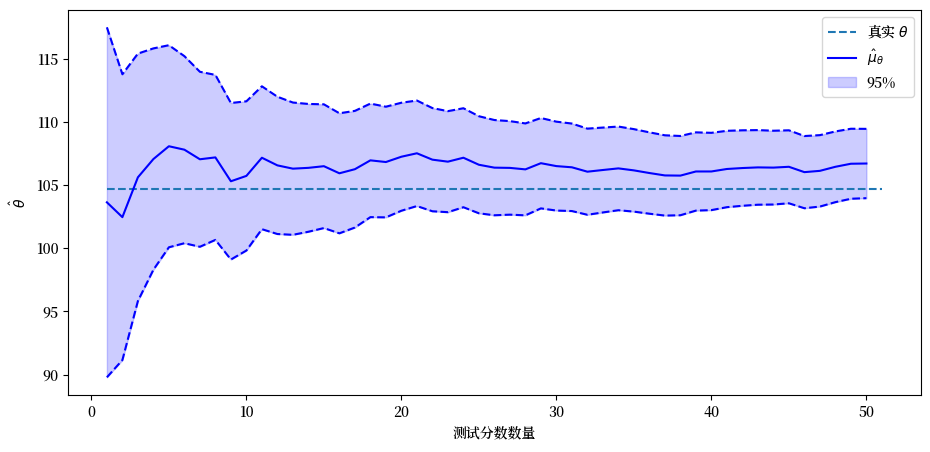

In [34]:
μθ_hat_lower = μθ_hat_arr - 1.96 * σθ_hat_arr
μθ_hat_higher = μθ_hat_arr + 1.96 * σθ_hat_arr

plt.hlines(θ, 1, n+1, ls='--', label='真实 $θ$')
plt.plot(range(1, n+1), μθ_hat_arr, color='b', label=r'$\hat{μ}_{θ}$')
plt.plot(range(1, n+1), μθ_hat_lower, color='b', ls='--')
plt.plot(range(1, n+1), μθ_hat_higher, color='b', ls='--')
plt.fill_between(range(1, n+1), μθ_hat_lower, μθ_hat_higher,
                 color='b', alpha=0.2, label='95%')

plt.xlabel('测试分数数量')
plt.ylabel('$\hat{θ}$')
plt.legend()

plt.show()

上图中的蓝色实线显示了$\hat{\mu}_{\theta}$作为我们已记录和条件化的测试分数数量的函数。

蓝色区域显示了从$\hat{\mu}_{\theta}$加上或减去$1.96 \hat{\sigma}_{\theta}$所得到的范围。

因此，条件分布的95%概率质量落在这个范围内。

黑色虚线显示了我们抽取的随机$\theta$的值。

随着越来越多的测试分数出现，我们对这个人的$\theta$的估计变得越来越可靠。

通过观察条件分布的变化，我们可以看到添加更多的测试分数使$\hat{\theta}$逐渐稳定并接近$\theta$。

因此，每个$y_{i}$都提供了关于$\theta$的信息。

如果我们让测试次数$n \rightarrow + \infty$，条件标准差$\hat{\sigma}_{\theta}$将以$\frac{1}{n^{.5}}$的速率收敛到$0$。

## 信息即惊奇

让我们通过使用不同的表示方法，从另一个角度来看这个问题。

我们可以将上述随机向量$X$表示为

$$
X = \mu_{\theta} \boldsymbol{1}_{n+1} + C \epsilon, \quad \epsilon \sim N\left(0, I\right)
$$

其中$C$是$\Sigma$的下三角**Cholesky因子**，使得

$$
\Sigma \equiv DD^{\prime} = C C^\prime
$$

且

$$
E \epsilon \epsilon' = I .
$$

因此可得

$$
\epsilon \sim N(0, I) .
$$

令$G=C^{-1}$

$G$也是下三角矩阵。

我们可以通过以下公式计算$\epsilon$

$$
\epsilon = G \left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)
$$

这个公式证实了正交向量$\epsilon$包含了与非正交向量$\left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)$相同的信息。

我们可以说$\epsilon$是$\left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)$的一个正交基。

令$c_{i}$为$C$最后一行的第$i$个元素。

那么我们可以写作

```{math}
:label: mnv_1

\theta = \mu_{\theta} + c_1 \epsilon_1 + c_2 \epsilon_2 + \dots + c_n \epsilon_n + c_{n+1} \epsilon_{n+1}
```

$\epsilon_i$ 之间的相互正交性为我们提供了一种有启发性的方式来解释方程 {eq}`mnv_1`。

因此，相对于从测试 $i=1, \ldots, n-1$ 已知的信息而言，$c_i \epsilon_i$ 是测试编号 $i$ 带来的关于 $\theta$ 的**新信息**量。

这里的**新信息**意味着**惊喜**或无法从先前信息预测的内容。

公式 {eq}`mnv_1` 还为我们提供了一种富有启发性的方式来表达我们之前计算的条件均值和条件方差。

具体来说，

$$
E\left[\theta \mid y_1, \dots, y_k\right] = \mu_{\theta} + c_1 \epsilon_1 + \dots + c_k \epsilon_k
$$

和

$$
Var\left(\theta \mid y_1, \dots, y_k\right) = c^2_{k+1} + c^2_{k+2} + \dots + c^2_{n+1}.
$$

In [35]:
C = np.linalg.cholesky(Σ_IQ)
G = np.linalg.inv(C)

ε = G @ (x - μθ)

In [36]:
cε = C[n, :] * ε

# 计算基于 y1, y2, ..., yk 的条件μθ和Σθ序列
μθ_hat_arr_C = np.array([np.sum(cε[:k+1]) for k in range(n)]) + μθ
Σθ_hat_arr_C = np.array([np.sum(C[n, i+1:n+1] ** 2) for i in range(n)])

为了确认这些公式给出的答案与我们之前计算的结果相同，我们可以将基于$\{y_i\}_{i=1}^k$条件下的$\theta$的均值和方差，与我们之前使用`MultivariateNormal`类（基于我们对多元正态分布条件分布的原始表示）实现的公式所得到的结果进行比较。

In [37]:
# 条件均值
np.max(np.abs(μθ_hat_arr - μθ_hat_arr_C)) < 1e-10

True

In [38]:
# 条件方差
np.max(np.abs(Σθ_hat_arr - Σθ_hat_arr_C)) < 1e-10

True

## Cholesky因子魔法

显然，Cholesky分解自动计算了我们的`MultivariateNormal`类所产生的总体**回归系数**和相关统计数据。

Cholesky分解**递归地**计算这些内容。

实际上，在公式{eq}`mnv_1`中，

- 随机变量$c_i \epsilon_i$包含了关于$\theta$的信息，这些信息不包含在$\epsilon_1, \epsilon_2, \ldots, \epsilon_{i-1}$的信息中
- 系数$c_i$是$\theta - \mu_\theta$对$\epsilon_i$的简单总体回归系数

## 数学和语言智力

我们可以修改前面的例子使其更加贴近现实。

有大量证据表明智商不是一个标量。

有些人数学能力强但语言能力差。

其他人语言能力强但数学能力差。

因此现在我们假设智商有两个维度，$\theta$和$\eta$。

这些分别决定了数学和语言测试的平均表现。

我们观察到数学分数 $\{y_i\}_{i=1}^{n}$ 和语言分数
$\{y_i\}_{i=n+1}^{2n}$。

当 $n=2$ 时，我们假设结果来自一个多元正态分布，其表示为

$$
X=\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
y_{4}\\
\theta\\
\eta
\end{array}\right]=\left[\begin{array}{c}
\mu_{\theta}\\
\mu_{\theta}\\
\mu_{\eta}\\
\mu_{\eta}\\
\mu_{\theta}\\
\mu_{\eta}
\end{array}\right]+\left[\begin{array}{cccccc}
\sigma_{y} & 0 & 0 & 0 & \sigma_{\theta} & 0\\
0 & \sigma_{y} & 0 & 0 & \sigma_{\theta} & 0\\
0 & 0 & \sigma_{y} & 0 & 0 & \sigma_{\eta}\\
0 & 0 & 0 & \sigma_{y} & 0 & \sigma_{\eta}\\
0 & 0 & 0 & 0 & \sigma_{\theta} & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{\eta}
\end{array}\right]\left[\begin{array}{c}
w_{1}\\
w_{2}\\
w_{3}\\
w_{4}\\
w_{5}\\
w_{6}
\end{array}\right]
$$

其中
$w \begin{bmatrix} w_1 \cr w_2 \cr \vdots \cr w_6 \end{bmatrix}$
是一个标准正态随机向量。

我们构建一个Python函数`construct_moments_IQ2d`来构造联合正态分布的均值向量和协方差矩阵。

In [39]:
def construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy):

    μ_IQ2d = np.empty(2*(n+1))
    μ_IQ2d[:n] = μθ
    μ_IQ2d[2*n] = μθ
    μ_IQ2d[n:2*n] = μη
    μ_IQ2d[2*n+1] = μη


    D_IQ2d = np.zeros((2*(n+1), 2*(n+1)))
    D_IQ2d[range(2*n), range(2*n)] = σy
    D_IQ2d[:n, 2*n] = σθ
    D_IQ2d[2*n, 2*n] = σθ
    D_IQ2d[n:2*n, 2*n+1] = ση
    D_IQ2d[2*n+1, 2*n+1] = ση

    Σ_IQ2d = D_IQ2d @ D_IQ2d.T

    return μ_IQ2d, Σ_IQ2d, D_IQ2d

让我们让函数开始工作。

In [40]:
n = 2
# θ、η和y的均值和方差
μθ, σθ, μη, ση, σy = 100., 10., 100., 10, 10

μ_IQ2d, Σ_IQ2d, D_IQ2d = construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy)
μ_IQ2d, Σ_IQ2d, D_IQ2d

(array([100., 100., 100., 100., 100., 100.]),
 array([[200., 100.,   0.,   0., 100.,   0.],
        [100., 200.,   0.,   0., 100.,   0.],
        [  0.,   0., 200., 100.,   0., 100.],
        [  0.,   0., 100., 200.,   0., 100.],
        [100., 100.,   0.,   0., 100.,   0.],
        [  0.,   0., 100., 100.,   0., 100.]]),
 array([[10.,  0.,  0.,  0., 10.,  0.],
        [ 0., 10.,  0.,  0., 10.,  0.],
        [ 0.,  0., 10.,  0.,  0., 10.],
        [ 0.,  0.,  0., 10.,  0., 10.],
        [ 0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.]]))

In [41]:
# 进行一次抽样
x = np.random.multivariate_normal(μ_IQ2d, Σ_IQ2d)
y1 = x[:n]
y2 = x[n:2*n]
θ = x[2*n]
η = x[2*n+1]

# 真实值
θ, η

(111.06790647488529, 79.50055336206911)

我们首先计算$\left(\theta, \eta\right)$的联合正态分布。

In [42]:
multi_normal_IQ2d = MultivariateNormal(μ_IQ2d, Σ_IQ2d)

k = 2*n # 数据向量的长度
multi_normal_IQ2d.partition(k)

multi_normal_IQ2d.cond_dist(1, [*y1, *y2])

(array([109.53870777,  80.01100487]),
 array([[33.33333333,  0.        ],
        [ 0.        , 33.33333333]]))

现在让我们分别计算基于各种测试分数子集条件下的 $\theta$ 和 $\mu$ 的分布。

通过构建一个辅助函数 `cond_dist_IQ2d`，我们可以有趣地比较各种结果。

In [43]:
def cond_dist_IQ2d(μ, Σ, data):

    n = len(μ)

    multi_normal = MultivariateNormal(μ, Σ)
    multi_normal.partition(n-1)
    μ_hat, Σ_hat = multi_normal.cond_dist(1, data)

    return μ_hat, Σ_hat

让我们看看这个例子是如何运行的。

In [44]:
for indices, IQ, conditions in [([*range(2*n), 2*n], 'θ', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n], 'θ', 'y1, y2'),
                                ([*range(n, 2*n), 2*n], 'θ', 'y3, y4'),
                                ([*range(2*n), 2*n+1], 'η', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n+1], 'η', 'y1, y2'),
                                ([*range(n, 2*n), 2*n+1], 'η', 'y3, y4')]:

    μ_hat, Σ_hat = cond_dist_IQ2d(μ_IQ2d[indices], Σ_IQ2d[indices][:, indices], x[indices[:-1]])
    print(f'在{conditions: <15}条件下，{IQ}的均值和方差分别为' +
          f'{μ_hat[0]:1.2f}和{Σ_hat[0, 0]:1.2f}')

在y1, y2, y3, y4 条件下，θ的均值和方差分别为109.54和33.33
在y1, y2         条件下，θ的均值和方差分别为109.54和33.33
在y3, y4         条件下，θ的均值和方差分别为100.00和100.00
在y1, y2, y3, y4 条件下，η的均值和方差分别为80.01和33.33
在y1, y2         条件下，η的均值和方差分别为100.00和100.00
在y3, y4         条件下，η的均值和方差分别为80.01和33.33


显然，数学考试不能提供关于 $\mu$ 的信息，语言考试不能提供关于 $\eta$ 的信息。

## 单变量时间序列分析

我们可以使用多元正态分布和一些矩阵代数来介绍单变量线性时间序列分析的基础。

设 $x_t, y_t, v_t, w_{t+1}$ 对于 $t \geq 0$ 均为标量。

考虑以下模型：

$$
\begin{aligned}
x_0 & \sim  N\left(0, \sigma_0^2\right) \\
x_{t+1} & = a x_{t} + b w_{t+1}, \quad w_{t+1} \sim N\left(0, 1\right), t \geq 0  \\
y_{t} & = c x_{t} + d v_{t}, \quad v_{t} \sim N\left(0, 1\right), t \geq 0
\end{aligned}
$$

我们可以计算 $x_{t}$ 的矩：

1. $E x_{t+1}^2 = a^2 E x_{t}^2 + b^2, t \geq 0$，其中
   $E x_{0}^2 = \sigma_{0}^2$
1. $E x_{t+j} x_{t} = a^{j} E x_{t}^2, \forall t \ \forall j$

给定某个 $T$，我们可以将序列 $\{x_{t}\}_{t=0}^T$ 表示为随机向量

$$
X=\left[\begin{array}{c}
x_{0}\\
x_{1}\\
\vdots\\
x_{T}
\end{array}\right]
$$

协方差矩阵 $\Sigma_{x}$ 可以用我们上面计算的矩来构建。

类似地，我们可以定义

$$
Y=\left[\begin{array}{c}
y_{0}\\
y_{1}\\
\vdots\\
y_{T}
\end{array}\right], \quad
v=\left[\begin{array}{c}
v_{0}\\
v_{1}\\
\vdots\\
v_{T}
\end{array}\right]
$$

因此

$$
Y = C X + D V
$$

其中 $C$ 和 $D$ 都是对角矩阵，对角线上分别为常数 $c$ 和 $d$。

因此，$Y$ 的协方差矩阵为

$$
\Sigma_{y} = E Y Y^{\prime} = C \Sigma_{x} C^{\prime} + D D^{\prime}
$$

通过将 $X$ 和 $Y$ 堆叠，我们可以写成

$$
Z=\left[\begin{array}{c}
X\\
Y
\end{array}\right]
$$

且

$$
\Sigma_{z} = EZZ^{\prime}=\left[\begin{array}{cc}
\Sigma_{x} & \Sigma_{x}C^{\prime}\\
C\Sigma_{x} & \Sigma_{y}
\end{array}\right]
$$

因此，堆叠序列 $\{x_{t}\}_{t=0}^T$ 和 $\{y_{t}\}_{t=0}^T$ 共同服从多元正态分布 $N\left(0, \Sigma_{z}\right)$。

In [45]:
# 作为示例，考虑 T = 3 的情况
T = 3

In [46]:
# 初始分布 x_0 的方差
σ0 = 1.

# 方程系统的参数
a = .9
b = 1.
c = 1.0
d = .05

In [47]:
# 构建 X 的协方差矩阵
Σx = np.empty((T+1, T+1))

Σx[0, 0] = σ0 ** 2
for i in range(T):
    Σx[i, i+1:] = Σx[i, i] * a ** np.arange(1, T+1-i)
    Σx[i+1:, i] = Σx[i, i+1:]

    Σx[i+1, i+1] = a ** 2 * Σx[i, i] + b ** 2

In [48]:
Σx

array([[1.      , 0.9     , 0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541]])

In [49]:
# 构建Y的协方差矩阵
C = np.eye(T+1) * c
D = np.eye(T+1) * d

Σy = C @ Σx @ C.T + D @ D.T

In [50]:
# 构建Z的协方差矩阵
Σz = np.empty((2*(T+1), 2*(T+1)))

Σz[:T+1, :T+1] = Σx
Σz[:T+1, T+1:] = Σx @ C.T
Σz[T+1:, :T+1] = C @ Σx
Σz[T+1:, T+1:] = Σy

In [51]:
Σz

array([[1.      , 0.9     , 0.81    , 0.729   , 1.      , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.81    ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 2.997541],
       [1.      , 0.9     , 0.81    , 0.729   , 1.0025  , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.8125  ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4686  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 3.000041]])

In [52]:
# 构建Z的均值向量
μz = np.zeros(2*(T+1))

以下 Python 代码让我们可以对随机向量 $X$ 和 $Y$ 进行采样。

这对于在下面有趣的练习中进行条件化处理将非常有用。

In [53]:
z = np.random.multivariate_normal(μz, Σz)

x = z[:T+1]
y = z[T+1:]

### 平滑示例

这是一个经典的`平滑`计算示例，其目的是计算$E X \mid Y$。

这个示例的解释是：

- $X$是一个隐马尔可夫状态变量$x_t$的随机序列
- $Y$是一个包含隐藏状态信息的观测信号$y_t$序列

In [54]:
# 构建一个多元正态分布实例
multi_normal_ex1 = MultivariateNormal(μz, Σz)
x = z[:T+1]
y = z[T+1:]

In [55]:
# 将Z分割成X和Y
multi_normal_ex1.partition(T+1)

In [56]:
# 计算给定Y=y时X的条件均值和协方差矩阵

print("X = ", x)
print("Y = ", y)
print(" E [ X | Y] = ", )

multi_normal_ex1.cond_dist(0, y)

X =  [-1.83758685 -1.13193571  0.14473619  0.29486267]
Y =  [-1.89170365 -1.14991592  0.07146159  0.32090162]
 E [ X | Y] = 


(array([-1.88575541, -1.14880464,  0.06928384,  0.32025686]),
 array([[2.48875094e-03, 5.57449314e-06, 1.24861718e-08, 2.80234724e-11],
        [5.57449314e-06, 2.48876343e-03, 5.57452116e-06, 1.25113935e-08],
        [1.24861718e-08, 5.57452116e-06, 2.48876346e-03, 5.58575339e-06],
        [2.80233614e-11, 1.25113933e-08, 5.58575339e-06, 2.49377812e-03]]))

### 滤波练习

计算 $E\left[x_{t} \mid y_{t-1}, y_{t-2}, \dots, y_{0}\right]$。

为此，我们首先需要构建子向量 $\left[x_{t}, y_{0}, \dots, y_{t-2}, y_{t-1}\right]$ 的均值向量和协方差矩阵。

例如，假设我们想要求 $x_{3}$ 的条件分布。

In [57]:
t = 3

In [58]:
# 子向量的均值
sub_μz = np.zeros(t+1)

# 子向量的协方差矩阵
sub_Σz = np.empty((t+1, t+1))

sub_Σz[0, 0] = Σz[t, t] # x_t
sub_Σz[0, 1:] = Σz[t, T+1:T+t+1]
sub_Σz[1:, 0] = Σz[T+1:T+t+1, t]
sub_Σz[1:, 1:] = Σz[T+1:T+t+1, T+1:T+t+1]

In [59]:
sub_Σz

array([[2.997541, 0.729   , 1.4661  , 2.21949 ],
       [0.729   , 1.0025  , 0.9     , 0.81    ],
       [1.4661  , 0.9     , 1.8125  , 1.629   ],
       [2.21949 , 0.81    , 1.629   , 2.4686  ]])

In [60]:
multi_normal_ex2 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex2.partition(1)

In [61]:
sub_y = y[:t]

multi_normal_ex2.cond_dist(0, sub_y)

(array([0.06183451]), array([[1.00201996]]))

### 预测练习

计算 $E\left[y_{t} \mid y_{t-j}, \dots, y_{0} \right]$。

如同我们在练习2中所做的那样，我们将构建子向量 $\left[y_{t}, y_{0}, \dots, y_{t-j-1}, y_{t-j} \right]$ 的均值向量和协方差矩阵。

例如，我们以 $t=3$ 且 $j=2$ 的情况为例。

In [62]:
t = 3
j = 2

In [63]:
sub_μz = np.zeros(t-j+2)
sub_Σz = np.empty((t-j+2, t-j+2))

sub_Σz[0, 0] = Σz[T+t+1, T+t+1]
sub_Σz[0, 1:] = Σz[T+t+1, T+1:T+t-j+2]
sub_Σz[1:, 0] = Σz[T+1:T+t-j+2, T+t+1]
sub_Σz[1:, 1:] = Σz[T+1:T+t-j+2, T+1:T+t-j+2]

In [64]:
sub_Σz

array([[3.000041, 0.729   , 1.4661  ],
       [0.729   , 1.0025  , 0.9     ],
       [1.4661  , 0.9     , 1.8125  ]])

In [65]:
multi_normal_ex3 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex3.partition(1)

In [66]:
sub_y = y[:t-j+1]

multi_normal_ex3.cond_dist(0, sub_y)

(array([-0.93253735]), array([[1.81413617]]))

### 构建沃尔德表示

现在我们将应用科列斯基分解来分解
$\Sigma_{y}=H H^{\prime}$ 并形成

$$
\epsilon = H^{-1} Y.
$$

然后我们可以将 $y_{t}$ 表示为

$$
y_{t} = h_{t,t} \epsilon_{t} + h_{t,t-1} \epsilon_{t-1} + \dots + h_{t,0} \epsilon_{0}.
$$

In [67]:
H = np.linalg.cholesky(Σy)

H

array([[1.00124922, 0.        , 0.        , 0.        ],
       [0.8988771 , 1.00225743, 0.        , 0.        ],
       [0.80898939, 0.89978675, 1.00225743, 0.        ],
       [0.72809046, 0.80980808, 0.89978676, 1.00225743]])

In [68]:
ε = np.linalg.inv(H) @ y

ε

array([-1.88934344,  0.54713652,  1.10511947,  0.2584836 ])

In [69]:
y

array([-1.89170365, -1.14991592,  0.07146159,  0.32090162])

这个例子是时间序列分析中所谓的**Wold表示**的一个实例。

## 随机差分方程

考虑二阶线性随机差分方程

$$
y_{t} = \alpha_{0} + \alpha_{1} y_{y-1} + \alpha_{2} y_{t-2} + u_{t}
$$

其中 $u_{t} \sim N \left(0, \sigma_{u}^{2}\right)$ 且

$$
\left[\begin{array}{c}
y_{-1}\\
y_{0}
\end{array}\right]\sim N\left(\mu_{\tilde{y}},\Sigma_{\tilde{y}}\right)
$$

它可以写成堆叠系统的形式

$$
\underset{\equiv A}{\underbrace{\left[\begin{array}{cccccccc}
1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0\\
-\alpha_{1} & 1 & 0 & 0 & \cdots & 0 & 0 & 0\\
-\alpha_{2} & -\alpha_{1} & 1 & 0 & \cdots & 0 & 0 & 0\\
0 & -\alpha_{2} & -\alpha_{1} & 1 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \cdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & -\alpha_{2} & -\alpha_{1} & 1
\end{array}\right]}}\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
y_{4}\\
\vdots\\
y_{T}

\end{array}\right]=\underset{\equiv b}{\underbrace{\left[\begin{array}{c}
\alpha_{0}+\alpha_{1}y_{0}+\alpha_{2}y_{-1}\\
\alpha_{0}+\alpha_{2}y_{0}\\
\alpha_{0}\\
\alpha_{0}\\
\vdots\\
\alpha_{0}
\end{array}\right]}} +\underset{\equiv u}{\underbrace{\left[\begin{array}{c}
u_{1} \\
u_2 \\
u_3\\
u_4\\
\vdots\\
u_T
\end{array}\right]}}
$$

我们可以通过求解以下系统来计算 $y$

$$
y = A^{-1} \left(b + u\right)
$$

我们有

$$
\begin{aligned}
\mu_{y} = A^{-1} \mu_{b} \\
\Sigma_{y} &= A^{-1} E \left[\left(b - \mu_{b} + u \right) \left(b - \mu_{b} + u \right)^{\prime}\right] \left(A^{-1}\right)^{\prime} \\
           &= A^{-1} \left(\Sigma_{b} + \Sigma_{u} \right) \left(A^{-1}\right)^{\prime}
\end{aligned}
$$

其中

$$
\mu_{b}=\left[\begin{array}{c}
\alpha_{0}+\alpha_{1}\mu_{y_{0}}+\alpha_{2}\mu_{y_{-1}}\\
\alpha_{0}+\alpha_{2}\mu_{y_{0}}\\
\alpha_{0}\\
\vdots\\
\alpha_{0}
\end{array}\right]
$$

$$
\Sigma_{b}=\left[\begin{array}{cc}

C\Sigma_{\tilde{y}}C^{\prime} & \boldsymbol{0}_{N-2\times N-2}\\
\boldsymbol{0}_{N-2\times2} & \boldsymbol{0}_{N-2\times N-2}
\end{array}\right],\quad C=\left[\begin{array}{cc}
\alpha_{2} & \alpha_{1}\\
0 & \alpha_{2}
\end{array}\right]
$$

$$
\Sigma_{u}=\left[\begin{array}{cccc}
\sigma_{u}^{2} & 0 & \cdots & 0\\
0 & \sigma_{u}^{2} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{u}^{2}
\end{array}\right]
$$

In [70]:
# 设置参数
T = 80
T = 160
# 二阶差分方程的系数
𝛼0 = 10
𝛼1 = 1.53
𝛼2 = -.9

# u的方差
σu = 1.
σu = 10.

# y_{-1}和y_{0}的分布
μy_tilde = np.array([1., 0.5])
Σy_tilde = np.array([[2., 1.], [1., 0.5]])

In [71]:
# 构建 A 和 A^{\prime}
A = np.zeros((T, T))

for i in range(T):
    A[i, i] = 1

    if i-1 >= 0:
        A[i, i-1] = -𝛼1

    if i-2 >= 0:
        A[i, i-2] = -𝛼2

A_inv = np.linalg.inv(A)

In [72]:
# 计算b和y的均值向量
μb = np.full(T, 𝛼0)
μb[0] += 𝛼1 * μy_tilde[1] + 𝛼2 * μy_tilde[0]
μb[1] += 𝛼2 * μy_tilde[1]

μy = A_inv @ μb

In [73]:
# 计算b和y的协方差矩阵
Σu = np.eye(T) * σu ** 2

Σb = np.zeros((T, T))

C = np.array([[𝛼2, 𝛼1], [0, 𝛼2]])
Σb[:2, :2] = C @ Σy_tilde @ C.T

Σy = A_inv @ (Σb + Σu) @ A_inv.T

## 应用于股票价格模型

令

$$
p_{t} = \sum_{j=0}^{T-t} \beta^{j} y_{t+j}
$$

构造

$$
\underset{\equiv p}{\underbrace{\left[\begin{array}{c}
p_{1}\\
p_{2}\\
p_{3}\\
\vdots\\
p_{T}
\end{array}\right]}}=\underset{\equiv B}{\underbrace{\left[\begin{array}{ccccc}
1 & \beta & \beta^{2} & \cdots & \beta^{T-1}\\
0 & 1 & \beta & \cdots & \beta^{T-2}\\
0 & 0 & 1 & \cdots & \beta^{T-3}\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & 1
\end{array}\right]}}\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
\vdots\\
y_{T}
\end{array}\right]
$$

我们得到

$$
\begin{aligned}
\mu_{p} = B \mu_{y} \\
\Sigma_{p} = B \Sigma_{y} B^{\prime}
\end{aligned}
$$

In [74]:
β = .96

In [75]:
# 构建 B
B = np.zeros((T, T))

for i in range(T):
    B[i, i:] = β ** np.arange(0, T-i)

记

$$
z=\left[\begin{array}{c}
y\\
p
\end{array}\right]=\underset{\equiv D}{\underbrace{\left[\begin{array}{c}
I\\
B
\end{array}\right]}} y
$$

因此，$\{y_t\}_{t=1}^{T}$ 和 $\{p_t\}_{t=1}^{T}$ 共同
服从多元正态分布
$N \left(\mu_{z}, \Sigma_{z}\right)$，其中

$$
\mu_{z}=D\mu_{y}
$$

$$
\Sigma_{z}=D\Sigma_{y}D^{\prime}
$$

In [76]:
D = np.vstack([np.eye(T), B])

In [77]:
μz = D @ μy
Σz = D @ Σy @ D.T

我们可以使用 `MultivariateNormal` 类来模拟 $y_{t}$ 和 $p_{t}$ 的路径，并计算条件期望 $E \left[p_{t} \mid y_{t-1}, y_{t}\right]$。

In [78]:
z = np.random.multivariate_normal(μz, Σz)
y, p = z[:T], z[T:]

In [79]:
cond_Ep = np.empty(T-1)

sub_μ = np.empty(3)
sub_Σ = np.empty((3, 3))
for t in range(2, T+1):
    sub_μ[:] = μz[[t-2, t-1, T-1+t]]
    sub_Σ[:, :] = Σz[[t-2, t-1, T-1+t], :][:, [t-2, t-1, T-1+t]]

    multi_normal = MultivariateNormal(sub_μ, sub_Σ)
    multi_normal.partition(2)

    cond_Ep[t-2] = multi_normal.cond_dist(1, y[t-2:t])[0][0]

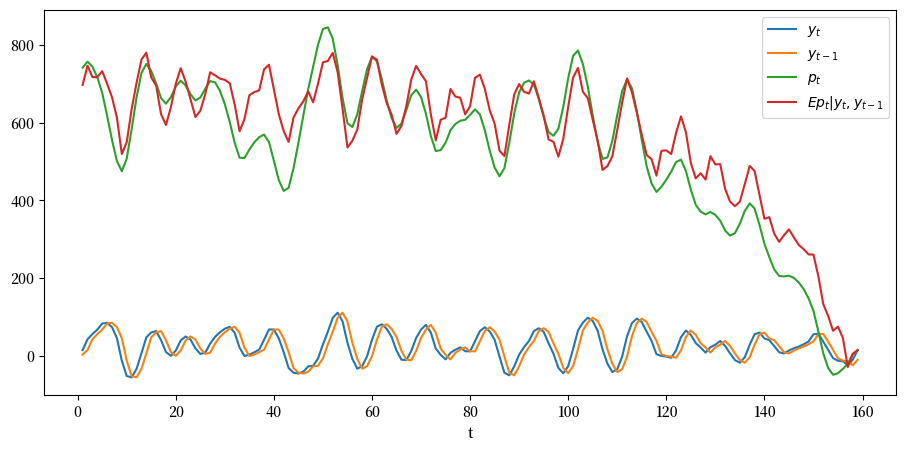

In [80]:
plt.plot(range(1, T), y[1:], label='$y_{t}$')
plt.plot(range(1, T), y[:-1], label='$y_{t-1}$')
plt.plot(range(1, T), p[1:], label='$p_{t}$')
plt.plot(range(1, T), cond_Ep, label='$Ep_{t}|y_{t}, y_{t-1}$')

plt.xlabel('t')
plt.legend(loc=1)
plt.show()

在上图中，绿线表示如果人们对股息路径有完美预见时的股票价格，而绿线表示条件期望 $E p_t | y_t, y_{t-1}$，这是在人们没有完美预见但基于时间 $t$ 的信息 $y_t, y_{t-1}$ 对未来股息进行最优预测时的股票价格。

## 滤波基础

假设 $x_0$ 是一个 $n \times 1$ 随机向量，且 $y_0$ 是一个由以下*观测方程*决定的 $p \times 1$ 随机向量

$$
y_0 = G x_0 + v_0  , \quad x_0 \sim {\mathcal N}(\hat x_0, \Sigma_0), \quad v_0 \sim {\mathcal N}(0, R)
$$

其中 $v_0$ 与 $x_0$ 正交，$G$ 是一个 $p \times n$ 矩阵，且 $R$ 是一个 $p \times p$ 正定矩阵。

我们考虑这样一个人的问题，他：

* *观察到* $y_0$
* 没有观察到 $x_0$

* 已知 $\hat x_0, \Sigma_0, G, R$ 以及向量 $\begin{bmatrix} x_0 \cr y_0 \end{bmatrix}$ 的联合概率分布
* 想要根据他所知道的联合概率分布，从 $y_0$ 推断 $x_0$。

因此，这个人想要构建基于随机向量 $y_0$ 的 $x_0$ 的条件概率分布。

$\begin{bmatrix} x_0 \cr y_0 \end{bmatrix}$ 的联合分布是多元正态分布 ${\mathcal N}(\mu, \Sigma)$，其中

$$
\mu = \begin{bmatrix} \hat x_0 \cr G \hat x_0 \end{bmatrix} , \quad
  \Sigma = \begin{bmatrix} \Sigma_0 & \Sigma_0 G' \cr
                          G \Sigma_0 & G \Sigma_0 G' + R \end{bmatrix}
$$

通过适当应用上述关于 $z_1$ 在给定 $z_2$ 条件下的均值向量 $\hat \mu_1$ 和协方差矩阵 $\hat \Sigma_{11}$ 的公式，我们发现 $x_0$ 在给定 $y_0$ 条件下的概率分布是 ${\mathcal N}(\tilde x_0, \tilde \Sigma_0)$，其中

$$

\begin{aligned} \beta_0  & = \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} \cr
\tilde x_0 & = \hat x_0 + \beta_0 ( y_0 - G \hat x_0) \cr
 \tilde \Sigma_0 & = \Sigma_0 - \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} G \Sigma_0
  \end{aligned}
$$

我们可以通过将$x_0$表示为以下形式来表达$x_0$在$y_0$条件下的概率分布为${\mathcal N}(\tilde x_0, \tilde \Sigma_0)$：

$$
 x_0 = \tilde x_0 + \zeta_0
$$ (eq:x0rep2)

其中$\zeta_0$是一个高斯随机向量，它与$\tilde x_0$和$y_0$正交，并且具有均值向量$0$和条件协方差矩阵$E [\zeta_0 \zeta_0' | y_0] = \tilde \Sigma_0$。

### 迈向动态分析

现在假设我们处在时间序列环境中，并且有一步状态转移方程：

$$
x_1 = A x_0 + C w_1 ,  \quad w_1 \sim {\mathcal N}(0, I )
$$

其中$A$是一个$n \times n$矩阵，$C$是一个$n \times m$矩阵。

使用方程{eq}`eq:x0rep2`，我们也可以将$x_1$表示为

$$

x_1 = A (\tilde x_0 + \zeta_0) + C w_1
$$

由此可得

$$ E x_1 | y_0 = A \tilde x_0
$$

相应的条件协方差矩阵 $E (x_1 - E x_1| y_0)  (x_1 - E x_1| y_0)' \equiv \Sigma_1$ 为

$$
 \Sigma_1 = A \tilde \Sigma_0 A' + C C'
$$

或

$$
\Sigma_1 =  A \Sigma_0 A' - A \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} G \Sigma_0 A'
$$

我们可以将 $x_1$ 在 $y_0$ 条件下的均值写作

$$
 \hat x_1 = A \hat x_0 + A \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} (y_0 - G \hat x_0)
$$

或

$$
 \hat x_1 = A \hat x_0 + K_0 (y_0 - G \hat x_0)
$$

其中

$$
K_0 = A \Sigma_0 G' (G \Sigma_0 G' + R)^{-1}
$$

### 动态版本

现在假设对于 $t \geq 0$，
$\{x_{t+1}, y_t\}_{t=0}^\infty$ 由以下方程支配

$$
\begin{aligned}
x_{t+1} & = A x_t + C w_{t+1} \cr
y_t & = G x_t + v_t
\end{aligned}
$$

其中如前所述 $x_0 \sim {\mathcal N}(\hat x_0, \Sigma_0)$，
$w_{t+1}$ 是独立同分布随机过程的第 $t+1$ 个分量

过程 $w_{t+1}$ 服从分布 $w_{t+1} \sim {\mathcal N}(0, I)$，而
$v_t$ 是独立同分布过程的第 $t$ 个分量，
服从分布 $v_t \sim {\mathcal N}(0, R)$，且
$\{w_{t+1}\}_{t=0}^\infty$ 和 $\{v_t\}_{t=0}^\infty$
这两个过程在任意时间点对上都是正交的。

我们上面应用的逻辑和公式表明，在给定
$y_0, y_1, \ldots , y_{t-1} = y^{t-1}$ 条件下，$x_t$ 的概率分布为

$$
x_t | y^{t-1} \sim {\mathcal N}(A \tilde x_t , A \tilde \Sigma_t A' + C C' )
$$

其中 $\{\tilde x_t, \tilde \Sigma_t\}_{t=1}^\infty$ 可以
通过从 $t=1$ 开始迭代以下方程计算得到，
初始条件 $\tilde x_0, \tilde \Sigma_0$ 按照我们上面的方法计算：

$$
\begin{aligned} \Sigma_t & = A  \tilde \Sigma_{t-1} A' + C C' \cr
               \hat x_t & = A \tilde x_{t-1} \cr
\beta_t & = \Sigma_t G' (G \Sigma_t G' + R)^{-1} \cr
\tilde x_t & = \hat x_t + \beta_t ( y_t - G \hat x_t) \cr

\tilde \Sigma_t & = \Sigma_t - \Sigma_t G' (G \Sigma_t G' + R)^{-1} G \Sigma_t
  \end{aligned}
$$

如果我们将第一个方程向前移动一个周期，然后将第五个方程右侧的$\tilde \Sigma_t$表达式代入其中，我们得到

$$
\Sigma_{t+1}= C C' + A \Sigma_t A' - A \Sigma_t G' (G \Sigma_t G' +R)^{-1} G \Sigma_t A' .
$$

这是一个矩阵黎卡提差分方程，它与另一个出现在线性二次控制理论基础的quantecon讲座中的矩阵黎卡提差分方程密切相关。

那个方程的形式为

```{math}

P_{t-1} =R + A' P_t A  - A' P_t B
(B' P_t B + Q)^{-1}  B' P_t A  .

```

请仔细观察前面这两个方程片刻，第一个是条件协方差矩阵的矩阵差分方程，第二个是出现在跨期成本值函数二次型中的矩阵的矩阵差分方程。

尽管这两个方程并不完全相同，但它们展现出显著的家族相似性。

* 第一个方程描述了**向前**推进的动态过程
* 第二个方程描述了**向后**推进的动态过程
* 虽然许多项都很相似，但一个方程似乎对在另一个方程中扮演相似角色的矩阵进行矩阵变换

这两个方程的家族相似性反映了控制理论和滤波理论之间存在的超越性**对偶**关系。

### 一个例子

我们可以使用Python类 *MultivariateNormal* 来构建示例。

这是一个时间为$0$的单期问题示例

In [81]:
G = np.array([[1., 3.]])
R = np.array([[1.]])

x0_hat = np.array([0., 1.])
Σ0 = np.array([[1., .5], [.3, 2.]])

μ = np.hstack([x0_hat, G @ x0_hat])
Σ = np.block([[Σ0, Σ0 @ G.T], [G @ Σ0, G @ Σ0 @ G.T + R]])

In [82]:
# 构建多元正态分布实例
multi_normal = MultivariateNormal(μ, Σ)

In [83]:
multi_normal.partition(2)

In [84]:
# y的观测值
y0 = 2.3

# x0的条件分布
μ1_hat, Σ11 = multi_normal.cond_dist(0, y0)
μ1_hat, Σ11

(array([-0.078125,  0.803125]),
 array([[ 0.72098214, -0.203125  ],
        [-0.403125  ,  0.228125  ]]))

In [85]:
A = np.array([[0.5, 0.2], [-0.1, 0.3]])
C = np.array([[2.], [1.]])

# x1的条件分布
x1_cond = A @ μ1_hat
Σ1_cond = C @ C.T + A @ Σ11 @ A.T
x1_cond, Σ1_cond

(array([0.1215625, 0.24875  ]),
 array([[4.12874554, 1.95523214],
        [1.92123214, 1.04592857]]))

### 迭代代码

以下是通过迭代方程来解决动态滤波问题的代码，并附有示例。

In [86]:
def iterate(x0_hat, Σ0, A, C, G, R, y_seq):

    p, n = G.shape

    T = len(y_seq)
    x_hat_seq = np.empty((T+1, n))
    Σ_hat_seq = np.empty((T+1, n, n))

    x_hat_seq[0] = x0_hat
    Σ_hat_seq[0] = Σ0

    for t in range(T):
        xt_hat = x_hat_seq[t]
        Σt = Σ_hat_seq[t]
        μ = np.hstack([xt_hat, G @ xt_hat])
        Σ = np.block([[Σt, Σt @ G.T], [G @ Σt, G @ Σt @ G.T + R]])

        # 滤波
        multi_normal = MultivariateNormal(μ, Σ)
        multi_normal.partition(n)
        x_tilde, Σ_tilde = multi_normal.cond_dist(0, y_seq[t])

        # 预测
        x_hat_seq[t+1] = A @ x_tilde
        Σ_hat_seq[t+1] = C @ C.T + A @ Σ_tilde @ A.T

    return x_hat_seq, Σ_hat_seq

In [87]:
iterate(x0_hat, Σ0, A, C, G, R, [2.3, 1.2, 3.2])

(array([[0.        , 1.        ],
        [0.1215625 , 0.24875   ],
        [0.18680212, 0.06904689],
        [0.75576875, 0.05558463]]),
 array([[[1.        , 0.5       ],
         [0.3       , 2.        ]],
 
        [[4.12874554, 1.95523214],
         [1.92123214, 1.04592857]],
 
        [[4.08198663, 1.99218488],
         [1.98640488, 1.00886423]],
 
        [[4.06457628, 2.00041999],
         [1.99943739, 1.00275526]]]))

刚才描述的迭代算法是著名的**卡尔曼滤波器**的一个版本。

我们在{doc}`卡尔曼滤波器初探 <kalman>`中描述了卡尔曼滤波器及其一些应用。

## 经典因子分析模型

在心理学和其他领域广泛使用的因子分析模型可以表示为：

$$
Y = \Lambda f + U
$$

其中：

1. $Y$ 是 $n \times 1$ 随机向量，
   $E U U^{\prime} = D$ 是一个对角矩阵，
1. $\Lambda$ 是 $n \times k$ 系数矩阵，
1. $f$ 是 $k \times 1$ 随机向量，
   $E f f^{\prime} = I$，
1. $U$ 是 $n \times 1$ 随机向量，且 $U \perp f$（即 $E U f' = 0$）
1. 假设 $k$ 相对于 $n$ 较小；通常
   $k$ 只有 $1$ 或 $2$，就像我们的智商示例中那样。

这意味着：

$$
\begin{aligned}
\Sigma_y = E Y Y^{\prime} = \Lambda \Lambda^{\prime} + D \\
E Y f^{\prime} = \Lambda \\
E f Y^{\prime} = \Lambda^{\prime}
\end{aligned}
$$

因此，协方差矩阵 $\Sigma_Y$ 是一个对角

矩阵 $D$ 和一个秩为 $k$ 的半正定矩阵 $\Lambda \Lambda^{\prime}$。

这意味着 $Y$ 向量的 $n$ 个分量之间的所有协方差都是通过它们与 $k<$ 个因子的共同依赖关系来中介的。

构造

$$
Z=\left(\begin{array}{c}
f\\
Y
\end{array}\right)
$$

扩展随机向量 $Z$ 的协方差矩阵可以计算为

$$
\Sigma_{z} = EZZ^{\prime}=\left(\begin{array}{cc}
I & \Lambda^{\prime}\\
\Lambda & \Lambda\Lambda^{\prime}+D
\end{array}\right)
$$

接下来，我们首先构造 $N=10$ 和 $k=2$ 情况下的均值向量和协方差矩阵。

In [88]:
N = 10
k = 2

我们设定系数矩阵$\Lambda$和$U$的协方差矩阵为

$$
\Lambda=\left(\begin{array}{cc}
1 & 0\\
\vdots & \vdots\\
1 & 0\\
0 & 1\\
\vdots & \vdots\\
0 & 1
\end{array}\right),\quad D=\left(\begin{array}{cccc}
\sigma_{u}^{2} & 0 & \cdots & 0\\
0 & \sigma_{u}^{2} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{u}^{2}
\end{array}\right)
$$

其中$\Lambda$的第一列前半部分填充为$1$，后半部分为$0$，第二列则相反。

$D$是一个对角矩阵，对角线上的元素为参数$\sigma_{u}^{2}$。

In [89]:
Λ = np.zeros((N, k))
Λ[:N//2, 0] = 1
Λ[N//2:, 1] = 1

σu = .5
D = np.eye(N) * σu ** 2

In [90]:
# 计算 Σy
Σy = Λ @ Λ.T + D

我们现在可以构建$Z$的均值向量和协方差矩阵。

In [91]:
μz = np.zeros(k+N)

Σz = np.empty((k+N, k+N))

Σz[:k, :k] = np.eye(k)
Σz[:k, k:] = Λ.T
Σz[k:, :k] = Λ
Σz[k:, k:] = Σy

In [92]:
z = np.random.multivariate_normal(μz, Σz)

f = z[:k]
y = z[k:]

In [93]:
multi_normal_factor = MultivariateNormal(μz, Σz)
multi_normal_factor.partition(k)

让我们计算隐藏因子$f$在观测值$Y$上的条件分布，即$f \mid Y=y$。

In [94]:
multi_normal_factor.cond_dist(0, y)

(array([ 1.1498889, -0.9083476]),
 array([[0.04761905, 0.        ],
        [0.        , 0.04761905]]))

我们可以验证条件期望
$E \left[f \mid Y=y\right] = B Y$ 其中
$B = \Lambda^{\prime} \Sigma_{y}^{-1}$。

In [95]:
B = Λ.T @ np.linalg.inv(Σy)

B @ y

array([ 1.1498889, -0.9083476])

类似地，我们可以计算条件分布 $Y \mid f$。

In [96]:
multi_normal_factor.cond_dist(1, f)

(array([ 1.51850567,  1.51850567,  1.51850567,  1.51850567,  1.51850567,
        -0.88080678, -0.88080678, -0.88080678, -0.88080678, -0.88080678]),
 array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]]))

可以验证该均值为
$\Lambda I^{-1} f = \Lambda f$。

In [97]:
Λ @ f

array([ 1.51850567,  1.51850567,  1.51850567,  1.51850567,  1.51850567,
       -0.88080678, -0.88080678, -0.88080678, -0.88080678, -0.88080678])

## PCA和因子分析

要了解主成分分析(PCA),请参阅本讲座{doc}`奇异值分解 <svd_intro>`。

让我们来做个有趣的练习,对实际上由我们的因子分析模型支配的协方差矩阵 $\Sigma_y$ 进行PCA分解。

从技术上讲,这意味着PCA模型是错误设定的。(你能解释为什么吗?)

尽管如此,这个练习将让我们研究PCA的前两个主成分如何近似我们假设真实支配Y数据的因子分析模型中两个因子 $f_i$ ($i=1,2$)的条件期望 $E f_i | Y$。

因此我们计算PCA分解

$$
\Sigma_{y} = P \tilde{\Lambda} P^{\prime}
$$

其中 $\tilde{\Lambda}$ 是一个对角矩阵。

我们有

$$
Y = P \epsilon
$$

和

$$
\epsilon = P^\prime Y
$$

注意,我们将按特征值*降序*排列 $P$ 中的特征向量。

In [98]:
𝜆_tilde, P = np.linalg.eigh(Σy)

# 按特征值排列特征向量
ind = sorted(range(N), key=lambda x: 𝜆_tilde[x], reverse=True)

P = P[:, ind]
𝜆_tilde = 𝜆_tilde[ind]
Λ_tilde = np.diag(𝜆_tilde)

print('𝜆_tilde =', 𝜆_tilde)

𝜆_tilde = [5.25 5.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [99]:
# 验证特征向量的正交性
np.abs(P @ P.T - np.eye(N)).max()

8.881784197001252e-16

In [100]:
# 验证特征值分解是否正确
P @ Λ_tilde @ P.T

array([[1.25, 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.25, 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.25, 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.25, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.  , 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.25, 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.25, 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.25, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.25]])

In [101]:
ε = P.T @ y

print("ε = ", ε)

ε =  [-2.13268332  2.69979123 -0.33692815  0.05695313 -0.21808164 -0.06542939
 -0.04374063 -0.2726217  -0.80741426  0.51412639]


In [102]:
# 打印两个因子的值

print('f = ', f)

f =  [ 1.51850567 -0.88080678]


下面我们将绘制几个图：

- $N$ 个 $y$ 值
- $N$ 个主成分 $\epsilon$ 值
- 第一个因子 $f_1$ 的值，仅绘制前 $N/2$ 个在 $\Lambda$ 中具有非零载荷的 $y$ 观测值
- 第二个因子 $f_2$ 的值，仅绘制最后 $N/2$ 个在 $\Lambda$ 中具有非零载荷的观测值

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7482/2845509298.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(range(N), ε, label='$\epsilon$')


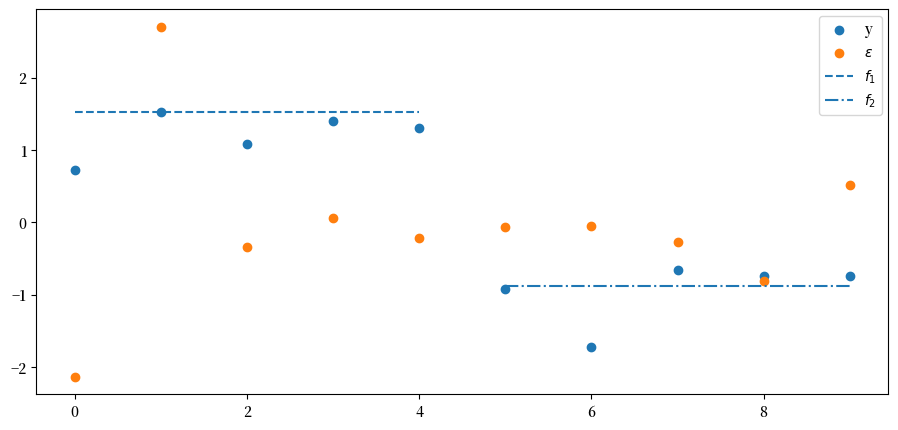

In [103]:
plt.scatter(range(N), y, label='y')
plt.scatter(range(N), ε, label='$\epsilon$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')
plt.legend()

plt.show()

因此，前两个 $\epsilon_{j}$ 对应于最大的两个特征值。

让我们来看看它们，之后我们将查看 $E f | y = B y$

In [104]:
ε[:2]

array([-2.13268332,  2.69979123])

In [105]:
# 与 Ef|y 比较
B @ y

array([ 1.1498889, -0.9083476])

$y_{t}$ 中由前两个主成分解释的方差比例可以按如下方式计算。

In [106]:
𝜆_tilde[:2].sum() / 𝜆_tilde.sum()

0.8400000000000001

计算

$$
\hat{Y} = P_{j} \epsilon_{j} + P_{k} \epsilon_{k}
$$

其中 $P_{j}$ 和 $P_{k}$ 对应最大的两个特征值。

In [107]:
y_hat = P[:, :2] @ ε[:2]

在这个例子中，Y在前两个主成分上的投影$\hat{Y}$很好地近似了$Ef \mid y$。

我们通过下面的图来确认这一点，图中展示了$f$、$E y \mid f$、$E f \mid y$和$\hat{y}$（在坐标轴上）与$y$（在纵轴上）的关系。

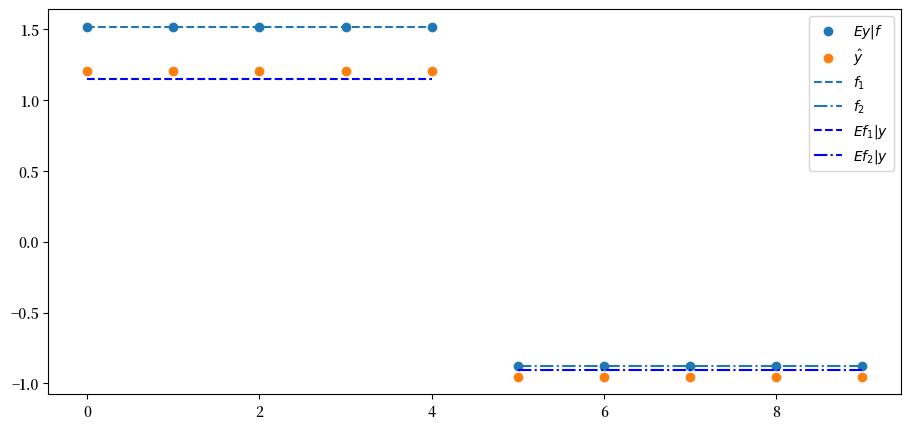

In [108]:
plt.scatter(range(N), Λ @ f, label='$Ey|f$')
plt.scatter(range(N), y_hat, label=r'$\hat{y}$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')

Efy = B @ y
plt.hlines(Efy[0], 0, N//2-1, ls='--', color='b', label='$Ef_{1}|y$')
plt.hlines(Efy[1], N//2, N-1, ls='-.', color='b', label='$Ef_{2}|y$')
plt.legend()

plt.show()

$\hat{Y}$ 的协方差矩阵可以通过先构建 $\epsilon$ 的协方差矩阵，然后使用 $\epsilon_{1}$ 和 $\epsilon_{2}$ 的左上角块来计算。

In [109]:
Σεjk = (P.T @ Σy @ P)[:2, :2]

Pjk = P[:, :2]

Σy_hat = Pjk @ Σεjk @ Pjk.T
print('Σy_hat = \n', Σy_hat)

Σy_hat = 
 [[1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]]
